In [13]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm

In [14]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [15]:
def plot_score_landscape_filtered(
    df,
    df_poly,
    x_param,
    y_param,
    allowed_missed_modules_val,
    figsize=(8, 5),
    cmap='viridis',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT",
    resolution=42,
    show_scatter=True,
    ax=None  # <-- for subplots
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata

    # filter polyhoot df on missed_modules
    if not df_poly.empty:
        # Add scatter points
        plt.scatter(df_poly[x_param], df_poly[y_param], color='red', label='PolyHoot')

        # Annotate each point with its index
        for idx, row in df_poly.iterrows():
            plt.annotate(str(idx), (row[x_param], row[y_param]), textcoords="offset points", xytext=(5, 5), ha='center')


    # Filter by allowed_missed_modules
    df_filtered = df[df['allowed_missed_modules'] == allowed_missed_modules_val]

    # Drop NaNs in relevant columns
    df_clean = df_filtered[[x_param, y_param, 'score']].dropna()

    if df_clean.empty:
        if ax is not None:
            ax.set_title(f"No data for allowed_missed_modules={allowed_missed_modules_val}")
            return
        else:
            print(f"No data for allowed_missed_modules={allowed_missed_modules_val}")
            return

    x = df_clean[x_param].values
    y = df_clean[y_param].values
    z = df_clean['score'].values

    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)

    try:
        zi = griddata((x, y), z, (xi, yi), method='cubic')
    except Exception as e:
        print("Cubic interpolation failed, falling back to linear:", e)
        zi = griddata((x, y), z, (xi, yi), method='linear')

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    im = ax.contourf(xi, yi, zi, levels=100, cmap=cmap, alpha=alpha)

    if show_scatter:
        sc = ax.scatter(x, y, c=z, cmap=cmap, edgecolor='k', marker='o', alpha=1.0)

    ax.set_title(title)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    # ax.set_xlim(0,0.05)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

In [16]:
# Set the file path:
path = "results/"
file_name = "result_GridSearch_ST_max.jsonl"
df = parse_results(path + file_name)
DF_polyhoot = parse_results("results/result_PolyHoot_ST_1_0b334e11-2d73-48cf-a880-c445b415abd3.jsonl")

val = 2, matching rows = 0
val = 3, matching rows = 0
val = 4, matching rows = 0


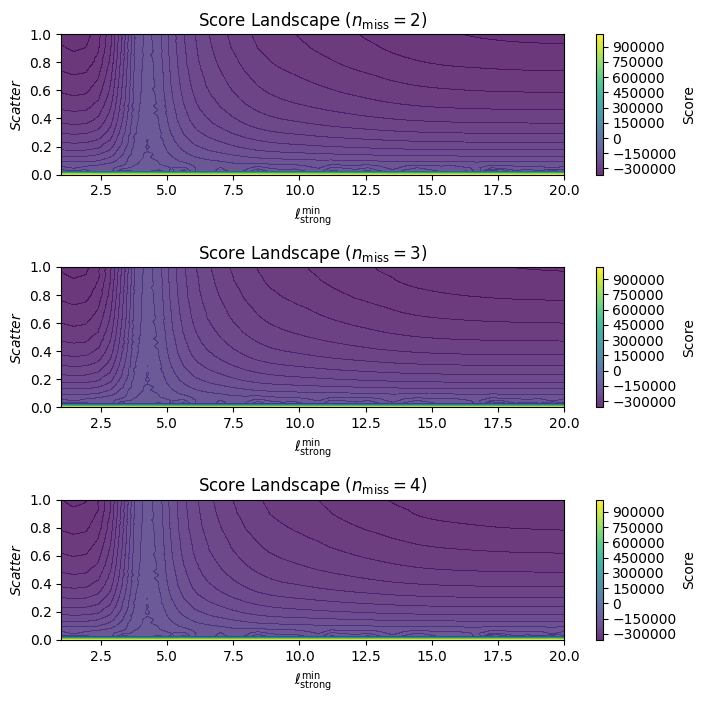

In [ ]:
allowed_values = [0, 1, 2, 3, 4]
allowed_values = [2,3,4]
fig, axs = plt.subplots(3, 1, figsize=(7.27, 10.69))

for i, val in enumerate(allowed_values):
    # df_filtered = DF_polyhoot[DF_polyhoot['allowed_missed_modules'] == float(val)]
    df_filtered = DF_polyhoot[DF_polyhoot['allowed_missed_modules'] == 10]
    print(f"val = {val}, matching rows = {len(df_filtered)}")
    plot_score_landscape_filtered(
        df,
        df_filtered,
        y_param='scatter',
        x_param='min_strong_track_length',
        allowed_missed_modules_val=val,
        title=f'Score Landscape ($n_{{\\mathrm{{miss}}}}=${val})',
        YTitle=r"$Scatter$",
        XTitle=r"$\ell_{\mathrm{strong}}^{\min}$",
        ax=axs[i],
        show_scatter=False
    )

plt.tight_layout()
plt.show()


In [18]:
DF_polyhoot.dropna().head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules
1,26d932dc-a8f5-4e84-b9c4-de2f2e14a794,24802.200622,18750,37.810805,31.563758,2.992019,49589,0.346153,0.25,10.0,2.0
2,c0d96ff2-e3ed-4d0c-998b-6e4f12aeffa5,30385.368676,31005,51.037037,44.845807,2.616335,60750,0.403171,0.75,10.0,2.0
3,4eda1de5-26e7-470e-b43b-72f4f0838fad,18651.647883,6578,17.637280,15.141903,2.833539,37296,0.301066,0.25,5.0,2.0
4,03e08b5e-76b0-401f-9013-080ca844cfb4,25856.664743,20825,40.282802,33.850950,3.001437,51697,0.270456,0.25,15.0,2.0
5,26d21a1c-9ff9-4c75-9634-cc327ca14fb1,18669.639394,6565,17.585449,15.106371,2.830382,37332,0.305760,0.25,5.0,1.0


In [19]:
print(DF_polyhoot['allowed_missed_modules'].dtype)

float64
